In [1]:
import numpy as np
import os
import torch
import torch.optim as optim
import torch.nn as nn

from torch.autograd import Variable
from torch.utils.data import DataLoader

from CNN_model import CNN
from load_data import DatasetFromHdf5
from utils import ts_to_np,np_to_ts,batch_psnr,plot_loss_save,plot_loss

check if GPU can be used

In [2]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


Parameters setting

In [3]:
batchSize=20
num_images=5000
epochs=200
image_size=32
print_every=50
lr=0.001
model_path='./model_dir'
iters=[]
y_loss=[]

Load training dataseta and testing dataset

In [4]:
train_set = DatasetFromHdf5("./dataset/train_mnist.h5")
test_set = DatasetFromHdf5("./dataset/test_mnist.h5")
training_data_loader = DataLoader(dataset=train_set,batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set,batch_size=batchSize, shuffle=True)

D:\pengyang\pytorch\DLGI\DNN\load_data.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(file_path)


Initialize the model and define the optimizer

In [5]:
model=CNN()
criterion=nn.MSELoss()
if torch.cuda.is_available:
    model.cuda()
    criterion.cuda()
    
optimizer=optim.Adam(model.parameters(),lr=lr)
device=torch.device('cuda:0' if GPU else 'cpu')

Training process

In [6]:
for epoch in range(1, epochs+1):
    #milestone
    if epoch>800:
        current_lr=lr/100.
    elif epoch>500:
        current_lr=lr/10.
    else:
        current_lr=lr
    
    for i, batch in enumerate(training_data_loader,1):
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        
        #obtain a batch of data and label
        data, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
        data=data.cuda()
        target = target.cuda()
        
        #input the data to the CNN
        out=model(data)
        
        #calculate the loss between the network output and label using MSE function
        loss=criterion(out,target)/(batchSize*2)
        
        loss.backward()
        optimizer.step()
           
        model.eval()
        
        #show the PSNR of the training data until now
        if i % print_every == 0:
            out_np=ts_to_np(out)
            target_np=ts_to_np(target)
    
            psnr_train=batch_psnr(out_np,target_np)
            print("[epoch %d][%d/%d] loss: %.10f PSNR_train: %.4f" % (epoch, i,len(training_data_loader), loss.item(), psnr_train))
    
    #save the loss value at this epoch    
    plot_loss_save(epoch,iters,y_loss,loss)       
#     torch.save(model.state_dict(), os.path.join(model_path, 'CNN_{}.pth'.format(epoch+1)))
    
        
    #verify the model efficiency with the trained model   
    model.eval() 
    psnr_test=0
    for i, batch in enumerate(testing_data_loader):
        data, target = Variable(batch[0]),Variable(batch[1], requires_grad=False)
        
        out_test=model(data.cuda())
        #print(out_val.shape)
        out_test_np=ts_to_np(out_test)
       
        target_np=ts_to_np(target)
      
        psnr_test+=batch_psnr(out_test_np,target_np)
        
            
    psnr_test /= len(testing_data_loader)
    print("\n[epoch %d] PSNR_test: %.4f" % (epoch, psnr_test))

torch.save(model.state_dict(), os.path.join(model_path, 'CNN_{}.pth'.format(epoch+1)))

[epoch 1][50/250] loss: 0.0009557310 PSNR_train: 14.7848
[epoch 1][100/250] loss: 0.0007288351 PSNR_train: 15.6743
[epoch 1][150/250] loss: 0.0005371521 PSNR_train: 16.9614
[epoch 1][200/250] loss: 0.0005187196 PSNR_train: 17.7509
[epoch 1][250/250] loss: 0.0004837354 PSNR_train: 17.9244

[epoch 1] PSNR_test: 18.3237
[epoch 2][50/250] loss: 0.0003527261 PSNR_train: 19.1225
[epoch 2][100/250] loss: 0.0003515625 PSNR_train: 19.2958
[epoch 2][150/250] loss: 0.0003929225 PSNR_train: 19.6655
[epoch 2][200/250] loss: 0.0003030020 PSNR_train: 19.7382
[epoch 2][250/250] loss: 0.0002779115 PSNR_train: 20.4902

[epoch 2] PSNR_test: 20.0033
[epoch 3][50/250] loss: 0.0002679197 PSNR_train: 20.1715
[epoch 3][100/250] loss: 0.0002457357 PSNR_train: 21.3983
[epoch 3][150/250] loss: 0.0002747801 PSNR_train: 19.9051
[epoch 3][200/250] loss: 0.0002352301 PSNR_train: 21.2012
[epoch 3][250/250] loss: 0.0002011883 PSNR_train: 21.8288

[epoch 3] PSNR_test: 20.9230
[epoch 4][50/250] loss: 0.0002071393 PSNR_t

[epoch 26][200/250] loss: 0.0000823527 PSNR_train: 25.4088
[epoch 26][250/250] loss: 0.0000869674 PSNR_train: 24.9663

[epoch 26] PSNR_test: 23.3005
[epoch 27][50/250] loss: 0.0000734528 PSNR_train: 26.5759
[epoch 27][100/250] loss: 0.0000791140 PSNR_train: 25.7355
[epoch 27][150/250] loss: 0.0000843463 PSNR_train: 25.3854
[epoch 27][200/250] loss: 0.0000753687 PSNR_train: 25.8331
[epoch 27][250/250] loss: 0.0000875357 PSNR_train: 25.1580

[epoch 27] PSNR_test: 23.2905
[epoch 28][50/250] loss: 0.0000843371 PSNR_train: 25.4300
[epoch 28][100/250] loss: 0.0000749761 PSNR_train: 25.9523
[epoch 28][150/250] loss: 0.0000646611 PSNR_train: 26.5204
[epoch 28][200/250] loss: 0.0000712416 PSNR_train: 25.8971
[epoch 28][250/250] loss: 0.0000725075 PSNR_train: 26.0152

[epoch 28] PSNR_test: 23.1809
[epoch 29][50/250] loss: 0.0000661934 PSNR_train: 26.2762
[epoch 29][100/250] loss: 0.0000743809 PSNR_train: 26.0833
[epoch 29][150/250] loss: 0.0000579498 PSNR_train: 26.8204
[epoch 29][200/250] loss:

[epoch 52][50/250] loss: 0.0000765002 PSNR_train: 26.3889
[epoch 52][100/250] loss: 0.0000495129 PSNR_train: 27.3973
[epoch 52][150/250] loss: 0.0000580627 PSNR_train: 27.2445
[epoch 52][200/250] loss: 0.0000684496 PSNR_train: 26.2390
[epoch 52][250/250] loss: 0.0000552159 PSNR_train: 27.1427

[epoch 52] PSNR_test: 23.4542
[epoch 53][50/250] loss: 0.0000562296 PSNR_train: 27.3409
[epoch 53][100/250] loss: 0.0000590050 PSNR_train: 26.7163
[epoch 53][150/250] loss: 0.0000588399 PSNR_train: 26.6177
[epoch 53][200/250] loss: 0.0000565847 PSNR_train: 26.9148
[epoch 53][250/250] loss: 0.0000575383 PSNR_train: 27.0044

[epoch 53] PSNR_test: 23.3219
[epoch 54][50/250] loss: 0.0000421123 PSNR_train: 28.0538
[epoch 54][100/250] loss: 0.0000497838 PSNR_train: 27.5220
[epoch 54][150/250] loss: 0.0000550207 PSNR_train: 27.2740
[epoch 54][200/250] loss: 0.0000605436 PSNR_train: 27.0151
[epoch 54][250/250] loss: 0.0000470051 PSNR_train: 27.5349

[epoch 54] PSNR_test: 23.3266
[epoch 55][50/250] loss: 

[epoch 77][150/250] loss: 0.0000449895 PSNR_train: 28.3547
[epoch 77][200/250] loss: 0.0000552534 PSNR_train: 27.1259
[epoch 77][250/250] loss: 0.0000512094 PSNR_train: 27.2401

[epoch 77] PSNR_test: 23.4121
[epoch 78][50/250] loss: 0.0000429601 PSNR_train: 28.0166
[epoch 78][100/250] loss: 0.0000381922 PSNR_train: 28.3857
[epoch 78][150/250] loss: 0.0000430716 PSNR_train: 27.8940
[epoch 78][200/250] loss: 0.0000466150 PSNR_train: 27.6458
[epoch 78][250/250] loss: 0.0000424135 PSNR_train: 27.9657

[epoch 78] PSNR_test: 23.3518
[epoch 79][50/250] loss: 0.0000395999 PSNR_train: 28.2433
[epoch 79][100/250] loss: 0.0000430493 PSNR_train: 27.8905
[epoch 79][150/250] loss: 0.0000474185 PSNR_train: 27.6311
[epoch 79][200/250] loss: 0.0000535199 PSNR_train: 27.2877
[epoch 79][250/250] loss: 0.0000481429 PSNR_train: 27.6734

[epoch 79] PSNR_test: 23.3563
[epoch 80][50/250] loss: 0.0000417392 PSNR_train: 28.0560
[epoch 80][100/250] loss: 0.0000427656 PSNR_train: 27.9865
[epoch 80][150/250] loss:

[epoch 102][200/250] loss: 0.0000446628 PSNR_train: 27.6303
[epoch 102][250/250] loss: 0.0000348736 PSNR_train: 28.7808

[epoch 102] PSNR_test: 23.1429
[epoch 103][50/250] loss: 0.0000365980 PSNR_train: 28.5665
[epoch 103][100/250] loss: 0.0000474072 PSNR_train: 27.4863
[epoch 103][150/250] loss: 0.0000474943 PSNR_train: 27.3597
[epoch 103][200/250] loss: 0.0000421167 PSNR_train: 27.8642
[epoch 103][250/250] loss: 0.0000408450 PSNR_train: 28.2924

[epoch 103] PSNR_test: 23.3076
[epoch 104][50/250] loss: 0.0000405681 PSNR_train: 28.2313
[epoch 104][100/250] loss: 0.0000347323 PSNR_train: 28.8201
[epoch 104][150/250] loss: 0.0000396402 PSNR_train: 28.4090
[epoch 104][200/250] loss: 0.0000480785 PSNR_train: 27.8281
[epoch 104][250/250] loss: 0.0000405233 PSNR_train: 28.5329

[epoch 104] PSNR_test: 23.2934
[epoch 105][50/250] loss: 0.0000349813 PSNR_train: 28.9410
[epoch 105][100/250] loss: 0.0000390294 PSNR_train: 28.3979
[epoch 105][150/250] loss: 0.0000373515 PSNR_train: 28.5708
[epoch 

[epoch 127][150/250] loss: 0.0000306368 PSNR_train: 29.4050
[epoch 127][200/250] loss: 0.0000373729 PSNR_train: 28.6920
[epoch 127][250/250] loss: 0.0000358569 PSNR_train: 28.5966

[epoch 127] PSNR_test: 23.3199
[epoch 128][50/250] loss: 0.0000339138 PSNR_train: 28.8134
[epoch 128][100/250] loss: 0.0000375815 PSNR_train: 28.5802
[epoch 128][150/250] loss: 0.0000343971 PSNR_train: 28.8655
[epoch 128][200/250] loss: 0.0000367390 PSNR_train: 28.6948
[epoch 128][250/250] loss: 0.0000306235 PSNR_train: 29.4411

[epoch 128] PSNR_test: 23.3366
[epoch 129][50/250] loss: 0.0000358174 PSNR_train: 28.5813
[epoch 129][100/250] loss: 0.0000330948 PSNR_train: 28.8644
[epoch 129][150/250] loss: 0.0000388282 PSNR_train: 28.3368
[epoch 129][200/250] loss: 0.0000354944 PSNR_train: 28.8916
[epoch 129][250/250] loss: 0.0000396241 PSNR_train: 28.3273

[epoch 129] PSNR_test: 23.3323
[epoch 130][50/250] loss: 0.0000336629 PSNR_train: 28.8319
[epoch 130][100/250] loss: 0.0000357033 PSNR_train: 28.6852
[epoch 

[epoch 152][100/250] loss: 0.0000319078 PSNR_train: 29.2222
[epoch 152][150/250] loss: 0.0000323131 PSNR_train: 29.1979
[epoch 152][200/250] loss: 0.0000310583 PSNR_train: 29.2005
[epoch 152][250/250] loss: 0.0000296646 PSNR_train: 29.5779

[epoch 152] PSNR_test: 23.2568
[epoch 153][50/250] loss: 0.0000316561 PSNR_train: 29.2164
[epoch 153][100/250] loss: 0.0000288581 PSNR_train: 29.7531
[epoch 153][150/250] loss: 0.0000286594 PSNR_train: 29.6330
[epoch 153][200/250] loss: 0.0000328653 PSNR_train: 29.0663
[epoch 153][250/250] loss: 0.0000372493 PSNR_train: 28.5209

[epoch 153] PSNR_test: 23.2107
[epoch 154][50/250] loss: 0.0000329216 PSNR_train: 29.1343
[epoch 154][100/250] loss: 0.0000299180 PSNR_train: 29.5185
[epoch 154][150/250] loss: 0.0000361409 PSNR_train: 28.7647
[epoch 154][200/250] loss: 0.0000315194 PSNR_train: 29.1831
[epoch 154][250/250] loss: 0.0000342093 PSNR_train: 28.9233

[epoch 154] PSNR_test: 23.3243
[epoch 155][50/250] loss: 0.0000280065 PSNR_train: 29.6571
[epoch 

[epoch 177][50/250] loss: 0.0000285530 PSNR_train: 29.6225
[epoch 177][100/250] loss: 0.0000394149 PSNR_train: 28.4045
[epoch 177][150/250] loss: 0.0000292690 PSNR_train: 29.4502
[epoch 177][200/250] loss: 0.0000288895 PSNR_train: 29.5927
[epoch 177][250/250] loss: 0.0000327503 PSNR_train: 29.0922

[epoch 177] PSNR_test: 23.1560
[epoch 178][50/250] loss: 0.0000302675 PSNR_train: 29.2789
[epoch 178][100/250] loss: 0.0000302060 PSNR_train: 29.3615
[epoch 178][150/250] loss: 0.0000310387 PSNR_train: 29.3025
[epoch 178][200/250] loss: 0.0000299252 PSNR_train: 29.3310
[epoch 178][250/250] loss: 0.0000304901 PSNR_train: 29.2241

[epoch 178] PSNR_test: 23.2849
[epoch 179][50/250] loss: 0.0000298492 PSNR_train: 29.4998
[epoch 179][100/250] loss: 0.0000309904 PSNR_train: 29.2954
[epoch 179][150/250] loss: 0.0000333204 PSNR_train: 28.8438
[epoch 179][200/250] loss: 0.0000331716 PSNR_train: 28.9264
[epoch 179][250/250] loss: 0.0000304102 PSNR_train: 29.2731

[epoch 179] PSNR_test: 23.2737
[epoch 

Plot the training loss

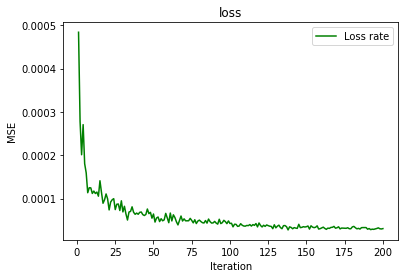

In [7]:
plot_loss(iters,y_loss)